<center><font size="10">Shah_Shrey_Project</font></center>


<font size="5">Name: Shrey Shah</font>
<br><font size="5">Github Username: shreyshah97</font>
<br><font size="5">USC ID: 5061063668</font>

## Installations (for google colab)

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Package Imports

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil
import splitfolders
import subprocess
import tensorflow as tf

from google.colab import drive
from IPython.display import clear_output 
from keras import layers, models, Model
from keras.applications import EfficientNetB0, ResNet50, VGG16
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, accuracy_score, ConfusionMatrixDisplay

In [3]:
drive.mount('/content/drive') 

gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0], 'GPU')

## Constants Declaration

In [4]:
images_path = "/content/drive/MyDrive/MLDS/Project/data/Data/Sport Images"
videos_path = "/content/drive/MyDrive/MLDS/Project/data/Data/Sport Videos"
split_images_path = "/content/drive/MyDrive/MLDS/Project/data/Data/Split Data"
temp_images_path = "/content/drive/MyDrive/MLDS/Project/data/Data/Temp/"
pre_trained_weights_path = "/content/drive/MyDrive/MLDS/Project/data/Pre-trained Weights/"
model_history_path = "/content/drive/MyDrive/MLDS/Project/data/Stats/"
image_dim = (224, 224)
image_shape = (224, 224, 3)
batch_size = 5
dropout_rate = 0.2

# 1. Transfer Learning for Video Classification

## A. Different Classes

In [5]:
print(sorted(os.listdir(images_path)))

['baseball', 'basketball', 'fencing', 'tennis', 'volleyball']


In [6]:
true_label = {}
idx = 0
for _, dirs, _ in os.walk(videos_path, topdown=False):
  dirs.sort()
  for name in dirs:
    true_label[name] = idx
    idx += 1

print(true_label)

{'BaseballPitch': 0, 'Basketball': 1, 'Fencing': 2, 'TennisSwing': 3, 'VolleyballSpiking': 4}


## B. Video Classification 

Videos can be viewed as a sequences of individual images; therefore, one can deal with video classification as performing image classification L times, where L is the number of frames in a video. However, this setting has a problem: it does not capture the temporal nature of the video. That is why we use RNN-CNN for video classification. Training RNN-CNN's needs a lot of computational resources, and it might sometimes be excessive, so in this project we will take a simpler approach.

## C. Moving Averages over Predictions for Video Classification  

In this approach, we train a CNN for image classification, and turn it into a video classifier using moving averages. If we rely on only one or a few frames of a video for classifying it, we will observe a phenomenon called 
flickering, which is assigning different labels to different frames of a video in the same class. However, if we use an average of predictions of probabilities for multiple frames, we will get a more reliable prediction for a video 

## D. Data Exploration and Pre-processing

In [7]:
def prepare_data(path):
  data = tf.keras.preprocessing.image_dataset_from_directory(
    path, image_size = image_dim, batch_size = batch_size,
  )
  return data.map(lambda a, b: (a, tf.one_hot(b, depth=5)))

In [8]:
shutil.rmtree(split_images_path, ignore_errors = True)
splitfolders.ratio(images_path, split_images_path, seed = 0, ratio = (0.7, 0.15, 0.15))

df_train = prepare_data(split_images_path + "/train")
df_val = prepare_data(split_images_path + "/val")
df_test = prepare_data(split_images_path + "/test")

Found 2292 files belonging to 5 classes.
Found 490 files belonging to 5 classes.
Found 497 files belonging to 5 classes.


## E. Transfer Learning via Image Classification

### i ii iii. Building models, Image augmentation, Last layer configuration 

In [9]:
augment = models.Sequential(
  [
    # Cropping results in worse performance of all the models, hence commenting it out.
    # layers.RandomCrop(height = 128, width = 256),
    layers.RandomZoom(height_factor = 0.1),
    layers.RandomRotation(factor = 0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor = 0.1),
    layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1)
  ],
  name = "augment",
)

def get_model(model_name, data):
  if model_name == "ResNet50":
    return ResNet50(include_top = False, input_tensor = data, weights = "imagenet")
  if model_name == "EfficientNetB0":
    return EfficientNetB0(include_top = False, input_tensor = data, weights = "imagenet")
  if model_name == "VGG16":
    return VGG16(include_top = False, input_tensor = data, weights = "imagenet")

def build_model(num_classes, model_name):
  inputs = layers.Input(shape = image_shape)
  data = augment(inputs)

  model = get_model(model_name, data)
  model.trainable = False

  data = layers.GlobalAveragePooling2D(name = "avg_pool")(model.output) 
  data = layers.Activation("relu")(data)
  data = layers.BatchNormalization()(data)
  data = layers.Dropout(dropout_rate)(data)    
  outputs = layers.Dense(num_classes, activation = "softmax")(data)
  return Model(inputs, outputs)
  
def get_callback(model_name):
  return [
    tf.keras.callbacks.ModelCheckpoint(filepath = pre_trained_weights_path + model_name + "_best_initial_weights.hdf5", 
                                       save_weights_only = True, monitor = 'val_accuracy', 
                                       mode = 'auto', save_best_only = True),
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'auto', start_from_epoch = 50)
  ]

### iv. Train models

In [10]:
os.makedirs(model_history_path, exist_ok = True)

#### VGG16

In [11]:
model_name, epochs = "VGG16", 100

model = build_model(5, model_name)
callbacks = get_callback(model_name)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 augment (Sequential)        (None, 224, 224, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1475

In [12]:
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
training_history = model.fit(df_train, epochs = epochs, callbacks = callbacks, validation_data = df_val)
np.save(model_history_path + model_name + '_initial_training.npy', training_history.history)

Epoch 1/100
459/459 [==============================] - 30s 55ms/step - loss: 1.3573 - accuracy: 0.4856 - val_loss: 0.8259 - val_accuracy: 0.7245
Epoch 2/100
459/459 [==============================] - 23s 50ms/step - loss: 1.0018 - accuracy: 0.6300 - val_loss: 0.6054 - val_accuracy: 0.7918
Epoch 3/100
459/459 [==============================] - 23s 49ms/step - loss: 0.9047 - accuracy: 0.6675 - val_loss: 0.5278 - val_accuracy: 0.8224
Epoch 4/100
459/459 [==============================] - 22s 47ms/step - loss: 0.8499 - accuracy: 0.6885 - val_loss: 0.4764 - val_accuracy: 0.8429
Epoch 5/100
459/459 [==============================] - 21s 46ms/step - loss: 0.8624 - accuracy: 0.6715 - val_loss: 0.4913 - val_accuracy: 0.8469
Epoch 6/100
459/459 [==============================] - 23s 51ms/step - loss: 0.8206 - accuracy: 0.6889 - val_loss: 0.4675 - val_accuracy: 0.8429
Epoch 7/100
459/459 [==============================] - 21s 45ms/step - loss: 0.8308 - accuracy: 0.6972 - val_loss: 0.4762 - val_ac

#### EfficientNetB0

In [13]:
model_name, epochs = "EfficientNetB0", 100

model = build_model(5, model_name)
callbacks = get_callback(model_name)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augment (Sequential)           (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['augment[2][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']      

In [14]:
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
training_history = model.fit(df_train, epochs = epochs, callbacks = callbacks, validation_data = df_val)
np.save(model_history_path + model_name + '_initial_training.npy', training_history.history)

Epoch 1/100
459/459 [==============================] - 25s 36ms/step - loss: 0.9230 - accuracy: 0.6771 - val_loss: 0.2559 - val_accuracy: 0.9204
Epoch 2/100
459/459 [==============================] - 14s 31ms/step - loss: 0.6565 - accuracy: 0.7823 - val_loss: 0.2646 - val_accuracy: 0.9204
Epoch 3/100
459/459 [==============================] - 15s 33ms/step - loss: 0.5962 - accuracy: 0.8089 - val_loss: 0.2090 - val_accuracy: 0.9388
Epoch 4/100
459/459 [==============================] - 14s 31ms/step - loss: 0.5818 - accuracy: 0.8045 - val_loss: 0.2293 - val_accuracy: 0.9327
Epoch 5/100
459/459 [==============================] - 15s 33ms/step - loss: 0.5509 - accuracy: 0.8089 - val_loss: 0.2366 - val_accuracy: 0.9327
Epoch 6/100
459/459 [==============================] - 14s 31ms/step - loss: 0.5239 - accuracy: 0.8207 - val_loss: 0.2164 - val_accuracy: 0.9306
Epoch 7/100
459/459 [==============================] - 14s 31ms/step - loss: 0.4930 - accuracy: 0.8377 - val_loss: 0.2172 - val_ac

#### ResNet50

In [15]:
model_name, epochs = "ResNet50", 100

model = build_model(5, model_name)
callbacks = get_callback(model_name)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 augment (Sequential)           (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['augment[4][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']        

In [16]:
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
training_history = model.fit(df_train, epochs = epochs, callbacks = callbacks, validation_data = df_val)
np.save(model_history_path + model_name + '_initial_training.npy', training_history.history)

Epoch 1/100
459/459 [==============================] - 27s 48ms/step - loss: 1.1811 - accuracy: 0.5982 - val_loss: 0.5874 - val_accuracy: 0.8122
Epoch 2/100
459/459 [==============================] - 21s 46ms/step - loss: 0.9141 - accuracy: 0.6963 - val_loss: 0.5424 - val_accuracy: 0.8490
Epoch 3/100
459/459 [==============================] - 19s 41ms/step - loss: 0.8517 - accuracy: 0.7256 - val_loss: 0.5906 - val_accuracy: 0.8408
Epoch 4/100
459/459 [==============================] - 17s 36ms/step - loss: 0.8567 - accuracy: 0.7155 - val_loss: 0.6458 - val_accuracy: 0.8347
Epoch 5/100
459/459 [==============================] - 20s 43ms/step - loss: 0.8059 - accuracy: 0.7295 - val_loss: 0.4615 - val_accuracy: 0.8571
Epoch 6/100
459/459 [==============================] - 19s 40ms/step - loss: 0.8411 - accuracy: 0.7378 - val_loss: 0.5461 - val_accuracy: 0.8551
Epoch 7/100
459/459 [==============================] - 21s 45ms/step - loss: 0.8605 - accuracy: 0.7404 - val_loss: 0.4289 - val_ac

### Findings

1. Validation Accuracies:<br>
  * <b>VGG16</b> has a validation accuracy of ~85%<br>
  * <b>EfficientNetB0</b> has a validation accuracy of ~93%<br>
  * <b>ResNet50</b> has a validation accuracy ~90%<br>
2. VGG performs slightly poorly compared to ResNet50 and EfficientNetB0 in terms of validation/training accuracy. This is expected as VGG16 is an older architecture and a relatively shallow network compared to ResNet50 and EfficientNetB0.
3. EfficientNetB0 performs the best amongst the three models in terms of validation accuracy.
4. Early stopping was applied with a patience of 10 after epoch 50 for all the three models and it's effect can be seen in all three models: 
  - VGG16: 66 epochs
  - EfficientNetB0: 67 epochs
  - ResNet50: 64 epochs

### v. Plot epoch vs error, confusion matrix, f1-score, accuracy, recall and precision

In [17]:
def plot_error_epoch_graph(stats, model_name):
  epochs = np.arange(1, len(stats['loss']) + 1)
  fig, axes = plt.subplots(1, 2, figsize = (10, 4))
  axes[0].plot(epochs, np.ones(len(epochs)) - stats['accuracy'], label = "Training Error")
  axes[0].plot(epochs, np.ones(len(epochs)) - stats['val_accuracy'], label = "Validation Error")
  axes[0].set_title("Training and Validation error vs Epochs", fontsize = 10)    
  axes[0].set_xlabel("Epochs")
  axes[0].set_ylabel("Error")
  axes[0].legend()

  axes[1].plot(epochs, stats['accuracy'], label = "Training Accuracy")
  axes[1].plot(epochs, stats['val_accuracy'], label = "Validation Accuracy")
  axes[1].set_title("Training and Validation Accuracy vs Epochs", fontsize = 10)    
  axes[1].set_xlabel("Epochs")
  axes[1].set_ylabel("Accuracy")
  axes[1].legend()

  fig.suptitle(model_name)
  plt.show()

def get_pred_true_labels(data, model):
  predictions, labels = [], []
  for x, y in data:
    predictions.append(np.argmax(model.predict(x, verbose = 0), axis = -1).tolist())
    labels.append(np.argmax(y.numpy(), axis=-1).tolist())

  predictions = [c for batch in predictions for c in batch]
  labels = [c for batch in labels for c in batch]
  model_results = classification_report(labels, predictions)
  conf_matrix = confusion_matrix(labels, predictions)
  return model_results, conf_matrix

def print_results(model_name):
  stats = np.load(model_history_path + model_name + '_initial_training.npy', allow_pickle = True).item()
  model = build_model(5, model_name)
  model.load_weights(pre_trained_weights_path + model_name + "_best_initial_weights.hdf5")

  plot_error_epoch_graph(stats, model_name)

  train_model_results, train_conf_matrix = get_pred_true_labels(df_train, model)
  test_model_results, test_conf_matrix = get_pred_true_labels(df_test, model)

  print("-----------------------------")
  print("Printing results for Training")
  print("-----------------------------")
  print(train_model_results)

  print("-----------------------------")
  print("Printing results for Testing")
  print("----------------------------")
  print(test_model_results)

  disp = ConfusionMatrixDisplay(train_conf_matrix)
  fig, ax = plt.subplots(1, 2, figsize = (10,4))
  ax[0].set_title("Confusion Matrix for Training")
  disp.plot(ax = ax[0])
  disp = ConfusionMatrixDisplay(test_conf_matrix)
  ax[1].set_title("Confusion Matrix for Testing")
  disp.plot(ax = ax[1])
  plt.show()

						 VGG16


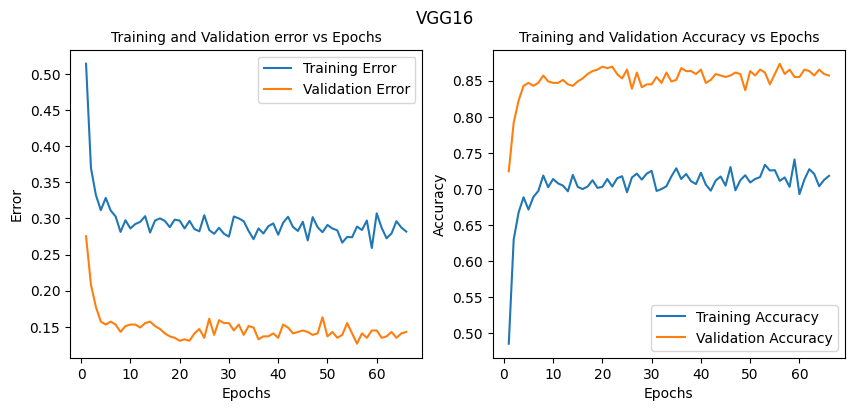

-----------------------------
Printing results for Training
-----------------------------
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       513
           1       0.84      0.89      0.86       344
           2       0.91      0.87      0.89       443
           3       0.91      0.85      0.88       500
           4       0.91      0.87      0.89       492

    accuracy                           0.88      2292
   macro avg       0.88      0.88      0.88      2292
weighted avg       0.88      0.88      0.88      2292

-----------------------------
Printing results for Testing
----------------------------
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       111
           1       0.77      0.85      0.81        75
           2       0.91      0.88      0.89        96
           3       0.87      0.83      0.85       108
           4       0.88      0.79      0.83       107

    acc

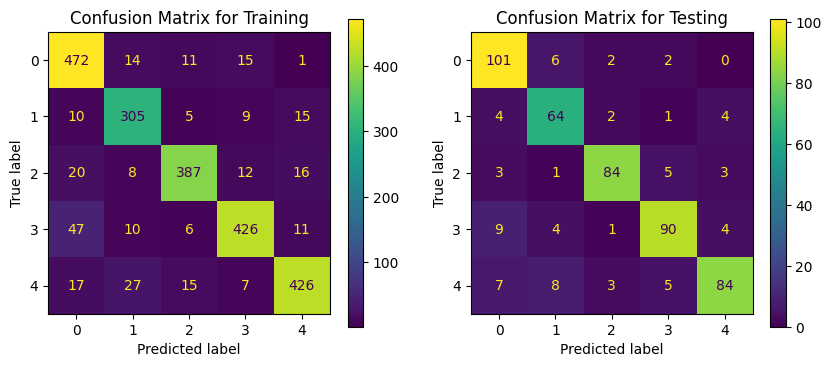

In [18]:
model_name = 'VGG16'
print("="*110)
print("\t\t\t\t\t\t", model_name)
print("="*110)
print_results(model_name)

						 EfficientNetB0


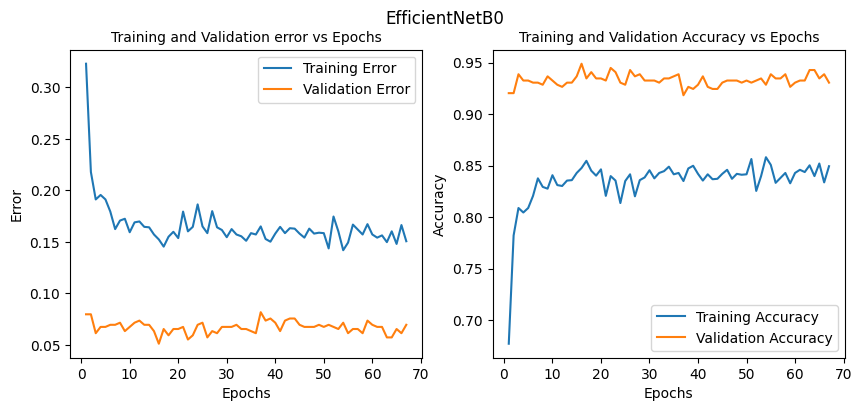

-----------------------------
Printing results for Training
-----------------------------
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       513
           1       0.98      0.97      0.97       344
           2       0.97      0.96      0.96       443
           3       0.97      0.97      0.97       500
           4       0.98      0.97      0.97       492

    accuracy                           0.97      2292
   macro avg       0.97      0.97      0.97      2292
weighted avg       0.97      0.97      0.97      2292

-----------------------------
Printing results for Testing
----------------------------
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       0.97      0.91      0.94        75
           2       0.90      0.97      0.93        96
           3       0.94      0.94      0.94       108
           4       0.94      0.93      0.93       107

    acc

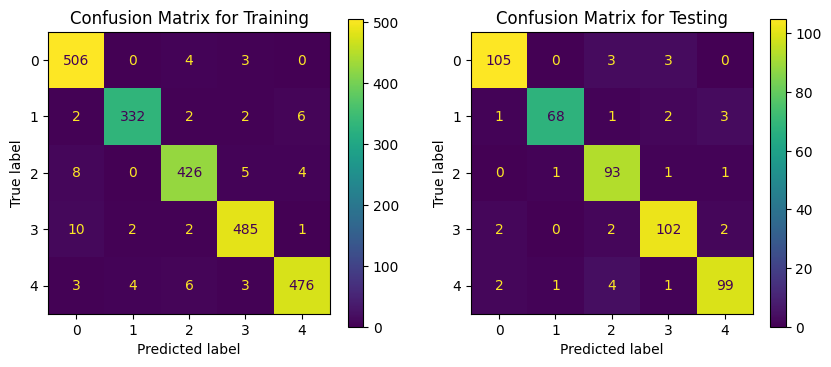

In [19]:
model_name = 'EfficientNetB0'
print("="*110)
print("\t\t\t\t\t\t", model_name)
print("="*110)
print_results(model_name)

						 ResNet50


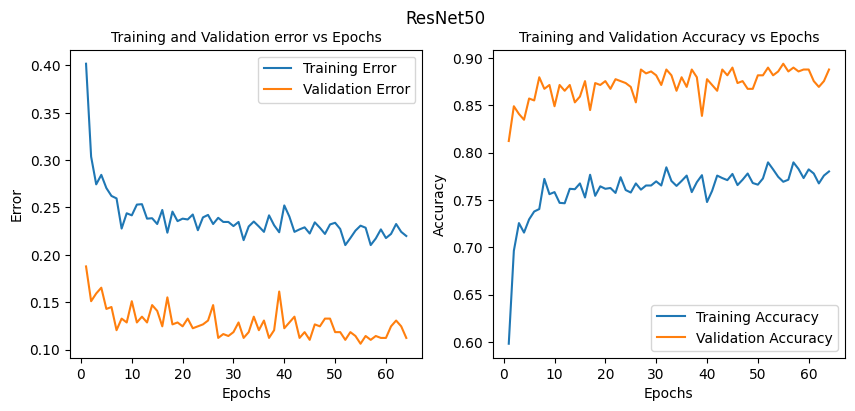

-----------------------------
Printing results for Training
-----------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       513
           1       0.87      0.95      0.91       344
           2       0.93      0.92      0.92       443
           3       0.95      0.90      0.93       500
           4       0.92      0.92      0.92       492

    accuracy                           0.92      2292
   macro avg       0.92      0.93      0.92      2292
weighted avg       0.93      0.92      0.93      2292

-----------------------------
Printing results for Testing
----------------------------
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       111
           1       0.80      0.89      0.84        75
           2       0.91      0.91      0.91        96
           3       0.88      0.87      0.87       108
           4       0.90      0.85      0.88       107

    acc

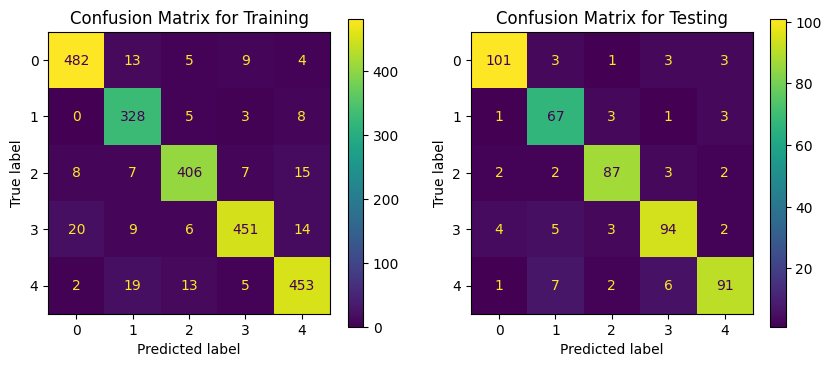

In [20]:
model_name = 'ResNet50'
print("="*110)
print("\t\t\t\t\t\t", model_name)
print("="*110)
print_results(model_name)

### Findings: 
1. Testing Accuracy:<br>
  * <b>VGG16</b> has a testing accuracy of ~85%<br>
  * <b>EfficientNetB0</b> has a testing accuracy of ~94% <br>
  * <b>ResNet50</b> has a testing accuracy of ~89%

2. We confirm that VGG16 indeed performs slightly worse as compared to the other two networks namely EfficientNetB0 and ResNet50 even on testing data.
3. We can also confirm that EfficientNetB0 is indeed the best performer even on test data.

## F.  Video Classification Using Moving Averages

### i. Train network over training + validation dataset + test dataset

#### VGG16

In [21]:
df_full = prepare_data(images_path)
model_name = "VGG16"
stats = np.load(model_history_path + model_name + '_initial_training.npy', allow_pickle = True).item()
epochs = len(stats['loss'])

model = build_model(5, model_name)
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
training_history = model.fit(df_full, epochs = epochs)
np.save(model_history_path + model_name + '_final_training.npy', training_history.history)
model.save_weights(pre_trained_weights_path + model_name + '_trained_final_weights.hdf5')

Found 3279 files belonging to 5 classes.
Epoch 1/66
656/656 [==============================] - 31s 42ms/step - loss: 1.2936 - accuracy: 0.5282
Epoch 2/66
656/656 [==============================] - 26s 39ms/step - loss: 0.9279 - accuracy: 0.6648
Epoch 3/66
656/656 [==============================] - 26s 40ms/step - loss: 0.8563 - accuracy: 0.6856
Epoch 4/66
656/656 [==============================] - 28s 42ms/step - loss: 0.8462 - accuracy: 0.6880
Epoch 5/66
656/656 [==============================] - 27s 41ms/step - loss: 0.8551 - accuracy: 0.6981
Epoch 6/66
656/656 [==============================] - 25s 38ms/step - loss: 0.7897 - accuracy: 0.7152
Epoch 7/66
656/656 [==============================] - 26s 40ms/step - loss: 0.8141 - accuracy: 0.7075
Epoch 8/66
656/656 [==============================] - 26s 39ms/step - loss: 0.7959 - accuracy: 0.7109
Epoch 9/66
656/656 [==============================] - 26s 39ms/step - loss: 0.8085 - accuracy: 0.7075
Epoch 10/66
656/656 [====================

#### EfficientNetB0

In [22]:
model_name = "EfficientNetB0"
stats = np.load(model_history_path + model_name + '_initial_training.npy', allow_pickle = True).item()
epochs = len(stats['loss'])

model = build_model(5, model_name)
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
training_history = model.fit(df_full, epochs = epochs)
np.save(model_history_path + model_name + '_final_training.npy', training_history.history)
model.save_weights(pre_trained_weights_path + model_name + '_trained_final_weights.hdf5')

Epoch 1/67
656/656 [==============================] - 24s 26ms/step - loss: 0.8267 - accuracy: 0.7164
Epoch 2/67
656/656 [==============================] - 18s 28ms/step - loss: 0.6150 - accuracy: 0.7981
Epoch 3/67
656/656 [==============================] - 18s 27ms/step - loss: 0.5970 - accuracy: 0.7996
Epoch 4/67
656/656 [==============================] - 18s 28ms/step - loss: 0.5462 - accuracy: 0.8320
Epoch 5/67
656/656 [==============================] - 20s 30ms/step - loss: 0.5355 - accuracy: 0.8213
Epoch 6/67
656/656 [==============================] - 18s 27ms/step - loss: 0.5475 - accuracy: 0.8307
Epoch 7/67
656/656 [==============================] - 18s 27ms/step - loss: 0.5381 - accuracy: 0.8262
Epoch 8/67
656/656 [==============================] - 20s 30ms/step - loss: 0.5284 - accuracy: 0.8280
Epoch 9/67
656/656 [==============================] - 18s 27ms/step - loss: 0.5726 - accuracy: 0.8188
Epoch 10/67
656/656 [==============================] - 18s 27ms/step - loss: 0.516

#### ResNet50

In [23]:
model_name = "ResNet50"
stats = np.load(model_history_path + model_name + '_initial_training.npy', allow_pickle = True).item()
epochs = len(stats['loss'])

model = build_model(5, model_name)
model.compile(optimizer = Adam(1e-3), loss = "categorical_crossentropy", metrics = ["accuracy"])
training_history = model.fit(df_full, epochs = epochs)
np.save(model_history_path + model_name + '_final_training.npy', training_history.history)
model.save_weights(pre_trained_weights_path + model_name + '_trained_final_weights.hdf5')

Epoch 1/64
656/656 [==============================] - 27s 33ms/step - loss: 1.1291 - accuracy: 0.6255
Epoch 2/64
656/656 [==============================] - 24s 36ms/step - loss: 0.9275 - accuracy: 0.7020
Epoch 3/64
656/656 [==============================] - 24s 37ms/step - loss: 0.8640 - accuracy: 0.7255
Epoch 4/64
656/656 [==============================] - 21s 32ms/step - loss: 0.8653 - accuracy: 0.7371
Epoch 5/64
656/656 [==============================] - 22s 34ms/step - loss: 0.8464 - accuracy: 0.7322
Epoch 6/64
656/656 [==============================] - 22s 33ms/step - loss: 0.8986 - accuracy: 0.7240
Epoch 7/64
656/656 [==============================] - 21s 32ms/step - loss: 0.8386 - accuracy: 0.7374
Epoch 8/64
656/656 [==============================] - 22s 33ms/step - loss: 0.8281 - accuracy: 0.7402
Epoch 9/64
656/656 [==============================] - 21s 32ms/step - loss: 0.8278 - accuracy: 0.7530
Epoch 10/64
656/656 [==============================] - 21s 32ms/step - loss: 0.787

### ii, iii, iv Perform video classification

In [24]:
def save_frames(video_path, dir_path = temp_images_path, ext = 'jpg'):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    return
  os.makedirs(dir_path + 'Temp', exist_ok = True)
  digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))
  frame_counts = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  n, total = 1, 0
  while True:
    ret, frame = cap.read()
    if not ret: 
      return
    total += 1
    if ret and (frame_counts <= 100 or (total % int(frame_counts / 100) == 0 and n <= 100)):
      cv2.imwrite(temp_images_path + 'Temp/img_{}.{}'.format(str(n).zfill(digit), ext), frame)
      n += 1

def get_prediction_for_videos(data, model):
  predictions, labels = [], []
  for x, y in data:
    predictions.extend(model.predict(x, verbose = 0))
  predictions = np.average(np.array(predictions), axis = 0)
  return np.argmax(predictions)

def write_result_to_csv(predicted_labels, actual_labels, folder_path = model_history_path):
  predicted_labels = pd.DataFrame(predicted_labels).reset_index(drop = True)
  actual_labels = pd.DataFrame(actual_labels).reset_index(drop = True)
  predicted_labels.columns = ['VGG16_pred', 'EfficientNetB0_pred', 'ResNet50_pred']
  actual_labels.columns = ['VGG16_actual', 'EfficientNetB0_actual', 'ResNet50_actual']
  ans = pd.concat([actual_labels, predicted_labels], axis = 1)
  ans.to_csv(folder_path + "video_classification_output.csv", index = False)

def read_output_csv(file_path = model_history_path + "video_classification_output.csv"):
  if not os.path.exists(file_path):
    return pd.DataFrame({})
  already_processed_data = pd.read_csv(file_path)
  return already_processed_data

def print_final_results(model_name):
  data = read_output_csv()
  model_results = classification_report(data[model_name + '_actual'], data[model_name + '_pred'])
  conf_matrix = confusion_matrix(data[model_name + '_actual'], data[model_name + '_pred'])
  print(model_results)
  disp = ConfusionMatrixDisplay(conf_matrix)
  fig, ax = plt.subplots(figsize = (5,3))
  disp.plot(ax = ax)

In [25]:
actual_labels = {'VGG16': [], 'EfficientNetB0': [], 'ResNet50': []}
predicted_labels = {'VGG16': [], 'EfficientNetB0': [], 'ResNet50': []}
models = {'VGG16': [], 'EfficientNetB0': [], 'ResNet50': []}
model_names = ['VGG16', 'EfficientNetB0', 'ResNet50']

already_processed_data = read_output_csv()
if already_processed_data.shape[0]:
  for model_name in model_names:
    actual_labels[model_name] = list(already_processed_data[model_name + '_actual'])
    predicted_labels[model_name] = list(already_processed_data[model_name + '_pred'])

for model_name in model_names: 
  model = build_model(5, model_name)
  model.load_weights(pre_trained_weights_path + model_name + "_trained_final_weights.hdf5")
  models[model_name] = model
  
already_processed_count = len(actual_labels[model_name])
print("Already processed videos: {}".format(already_processed_count))
print("Strating processing from: {}".format(already_processed_count + 1))

count = 0
for folder in sorted(os.listdir(videos_path)):
  for video in os.listdir(videos_path + '/' + folder):

    count += 1
    if count <= already_processed_count:
      continue

    shutil.rmtree(temp_images_path, ignore_errors = True)
    save_frames(videos_path + '/' + folder + '/' + video)
    temp_df = prepare_data(temp_images_path)
    
    clear_output()
    print("Working on: {}/681".format(count))
    
    for model_name in model_names:
      predicted_labels[model_name].append(get_prediction_for_videos(temp_df, models[model_name]))
      actual_labels[model_name].append(true_label[folder])
    
    write_result_to_csv(predicted_labels, actual_labels)
    if count % 5 == 0:
      write_result_to_csv(predicted_labels, actual_labels, "")

shutil.rmtree(temp_images_path, ignore_errors = True)

Working on: 681/681


Printing Test Results for Model: VGG16
              precision    recall  f1-score   support

           0       0.61      0.85      0.71       150
           1       0.86      0.04      0.08       137
           2       0.32      0.90      0.47       111
           3       0.77      0.42      0.54       167
           4       0.34      0.17      0.23       116

    accuracy                           0.48       681
   macro avg       0.58      0.48      0.41       681
weighted avg       0.61      0.48      0.42       681



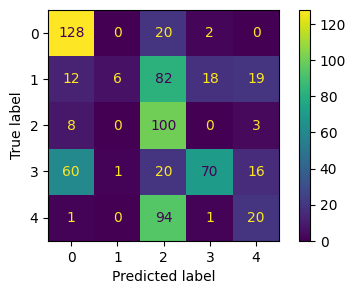

In [26]:
model_name = 'VGG16'
print("="*52)
print("Printing Test Results for Model: {}".format(model_name))
print_final_results(model_name)
print("="*52)

Printing Test Results for Model: EfficientNetB0
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       150
           1       0.80      0.03      0.06       137
           2       0.50      0.92      0.64       111
           3       0.74      0.89      0.81       167
           4       0.50      0.41      0.45       116

    accuracy                           0.65       681
   macro avg       0.67      0.64      0.57       681
weighted avg       0.69      0.65      0.58       681



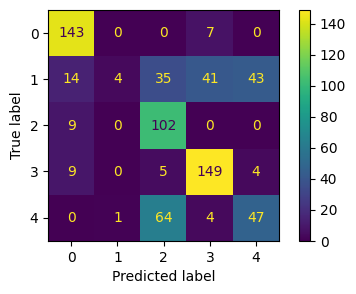

In [27]:
model_name = 'EfficientNetB0'
print("="*52)
print("Printing Test Results for Model: {}".format(model_name))
print_final_results(model_name)
print("="*52)

Printing Test Results for Model: ResNet50
              precision    recall  f1-score   support

           0       0.54      0.99      0.70       150
           1       0.22      0.01      0.03       137
           2       0.37      0.67      0.48       111
           3       0.77      0.55      0.64       167
           4       0.46      0.31      0.37       116

    accuracy                           0.52       681
   macro avg       0.47      0.51      0.44       681
weighted avg       0.49      0.52      0.46       681



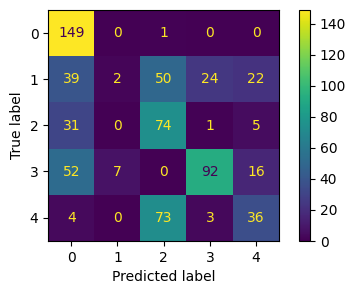

In [28]:
model_name = 'ResNet50'
print("="*52)
print("Printing Test Results for Model: {}".format(model_name))
print_final_results(model_name)
print("="*52)

# Reference

1. https://www.tensorflow.org/tutorials/images/data_augmentation
2. https://keras.io/guides/transfer_learning/
3. https://pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/ 
4. https://note.nkmk.me/en/python-opencv-video-to-still-image/